# **Tecnológico de Costa Rica**

![TEC](https://www.eslared.net/sites/default/files/2020-06/tec_logo.png)


***IC-4213 / Inteligencia artificial***

Autores


*   **Sebastian Matey Rodriguez**
*   **Liz Iveth Salazar Salazar**
*   **Roosevelt Alejandro Pérez González**

#Análisis del Problema


El conjunto de datos proporcionado contiene información sobre películas, incluyendo las calificaciones de los usuarios (ratings.csv) y los géneros de las películas (movies.csv). Este dataset es ideal para desarrollar un sistema de recomendación de películas basado en los ratings y los géneros que los usuarios asignan a las películas. El problema consiste en predecir qué películas podrían interesar a un usuario en función de sus calificaciones previas y las similitudes entre películas. Para resolver este problema, se aplicó un enfoque de Filtrado Colaborativo utilizando el algoritmo K-Nearest Neighbors (KNN). Este modelo busca identificar las películas más similares a las que un usuario ya ha calificado positivamente, recomendando aquellas que no ha visto pero que otros usuarios similares sí han calificado favorablemente. La calidad del modelo se evaluó mediante RMSE (Root Mean Squared Error) para medir la precisión de las calificaciones predichas en comparación con las calificaciones reales. Además, se utilizó Precision y Recall para evaluar cuán relevantes son las recomendaciones generadas por el modelo. Los resultados obtenidos muestran que el sistema de recomendación tiene una efectividad razonable en términos de relevancia y precisión,

# Entendimiento de los Datos

## Carga de los datos

In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", 120)

In [3]:
# Rutas (si los subes directo al entorno de Colab)
MOVIES_PATH  = "/content/movies.csv"
RATINGS_PATH = "/content/ratings.csv"

# Lectura robusta (UTF-8 confirmado en la inspección)
read_kwargs = dict(encoding="utf-8")

df_movies  = pd.read_csv(MOVIES_PATH,  **read_kwargs)
df_ratings = pd.read_csv(RATINGS_PATH, **read_kwargs)

print("movies:",  df_movies.shape,  list(df_movies.columns))
print("ratings:", df_ratings.shape, list(df_ratings.columns))

# Comprobaciones básicas de esquema
assert {"movieId","title","genres"}.issubset(df_movies.columns),  "movies.csv no tiene las columnas esperadas"
assert {"userId","movieId","rating"}.issubset(df_ratings.columns), "ratings.csv no tiene las columnas esperadas"

# Tipos: rating numérico
df_ratings["rating"] = pd.to_numeric(df_ratings["rating"], errors="coerce")

movies: (10329, 3) ['movieId', 'title', 'genres']
ratings: (105339, 4) ['userId', 'movieId', 'rating', 'timestamp']


In [4]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),Animation|Children|Comedy
10325,146878,Le Grand Restaurant (1966),Comedy
10326,148238,A Very Murray Christmas (2015),Comedy
10327,148626,The Big Short (2015),Drama


In [5]:
df_ratings

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523
...,...,...,...,...
105334,668,142488,4.0,1451535844
105335,668,142507,3.5,1451535889
105336,668,143385,4.0,1446388585
105337,668,144976,2.5,1448656898


Los datasets proporcionados contienen dos tablas clave para el modelo de recomendación: df_movies y df_ratings.


*   df_movies: Este dataset contiene información sobre las películas, como el ID de la película, el título y los géneros. En total, hay 10,329 películas. La columna de géneros se presenta como una lista separada por barras verticales (|), lo que permite una clasificación multifacética de cada película. Por ejemplo, "Toy Story (1995)" pertenece a los géneros "Adventure", "Animation", "Children", "Comedy" y "Fantasy". Este enfoque facilita la categorización y el análisis de las similitudes entre las películas basadas en géneros comunes.

*   df_ratings: Este dataset tiene 105,339 calificaciones de los usuarios para las películas, con las columnas userId, movieId, rating, y timestamp. Cada calificación está asociada a un usuario, que indica qué película ha calificado y con qué puntaje. El puntaje va de 0.5 a 5, lo que permite una variabilidad en las preferencias de los usuarios. Esta tabla es fundamental para el sistema de recomendación, ya que nos permite analizar el comportamiento y las preferencias de los usuarios, generando recomendaciones basadas en las calificaciones previas.

#Exploración de los datos

## Analisis de los datos

In [6]:
# Información general del dataset
df_movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [9]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [11]:
df_movies.describe()

,movieId
count,10329.000000
mean,31924.282893
std,37734.741149
min,1.000000
25%,3240.000000
50%,7088.000000
75%,59900.000000
max,149532.000000


In [10]:
# Estadísticas descriptivas de las columnas numéricas
df_ratings.describe()


,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


El dataset de películas (df_movies) contiene un total de 10,329 películas. La columna movieId tiene un rango que va desde 1 hasta 149532, lo que indica que aunque hay una gran cantidad de posibles identificadores de películas en el sistema, el conjunto de datos solo contiene una fracción de esas películas. La media de movieId es de 31,924, lo que sugiere que los identificadores de las películas están distribuidos de manera amplia, pero no abarcan todo el rango disponible. En cuanto a la columna de géneros, cada película está asociada con uno o más géneros, lo que aumenta la complejidad de las recomendaciones, dado que una misma película puede pertenecer a varios géneros como "Acción", "Aventura" o "Comedia". Este enfoque multifacético es útil para hacer recomendaciones basadas en las preferencias de los usuarios por género, aunque también puede hacer que el modelo sea más complejo de entrenar.

El dataset de calificaciones (df_ratings) contiene 105,339 calificaciones realizadas por 668 usuarios distintos, con un rango de calificación que varía entre 0.5 y 5.0. La media de calificación es de 3.52, lo que indica que los usuarios tienden a ser moderadamente positivos en sus valoraciones. Además, la desviación estándar de 1.04 muestra que las calificaciones no son completamente homogéneas, sino que hay una variedad significativa de opiniones entre los usuarios. Esto es esperado en sistemas de recomendación, ya que los gustos de los usuarios pueden variar ampliamente. En cuanto a la columna de timestamp, se puede usar para analizar la evolución de las preferencias de los usuarios a lo largo del tiempo, aunque en este caso, no se emplea directamente en el modelo de recomendación.

In [12]:
# Verificar la cantidad de valores nulos en cada columna
print("Missing values in Movies Dataset:")
print(df_movies.isnull().sum())

print("Missing values in Ratings Dataset:")
print(df_ratings.isnull().sum())


Missing values in Movies Dataset:
movieId    0
title      0
genres     0
dtype: int64
Missing values in Ratings Dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [13]:
# Verificar duplicados
print(f"Duplicados en Movies: {df_movies.duplicated().sum()}")
print(f"Duplicados en Ratings: {df_ratings.duplicated().sum()}")


Duplicados en Movies: 0
Duplicados en Ratings: 0


## Distribuciones

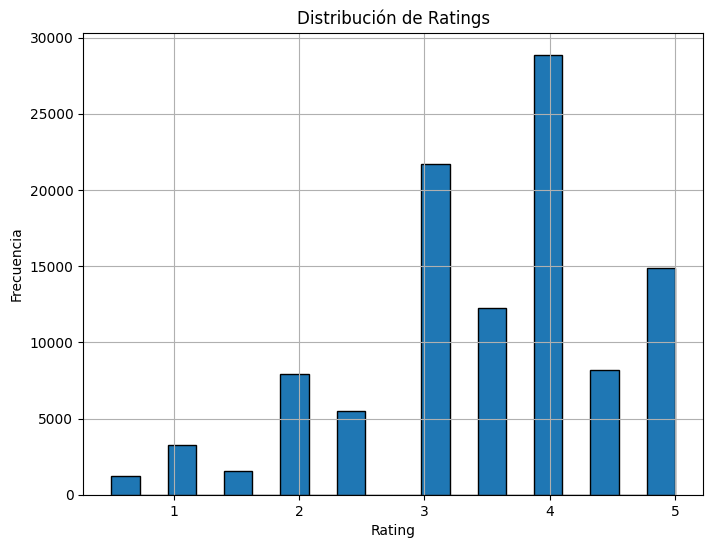

In [14]:
# Distribución de los ratings
plt.figure(figsize=(8, 6))
df_ratings['rating'].hist(bins=20, edgecolor='black')
plt.title("Distribución de Ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

El gráfico muestra la distribución de ratings en el dataset de calificaciones (df_ratings). En él, se puede observar que las calificaciones no están distribuidas uniformemente, sino que siguen una tendencia hacia valores más altos:

* La calificación 3 es la más frecuente, con una cantidad significativa de calificaciones cercanas a ella. Esto sugiere que los usuarios tienden a ser más neutrales o moderados en sus valoraciones, sin llegar a calificar las películas con extremos de "1" o "5".

* La calificación 4 también tiene una frecuencia considerable, lo que indica que los usuarios en su mayoría valoran positivamente las películas, pero sin llegar a ser completamente entusiastas.

* Las calificaciones 1 y 2 son mucho menos frecuentes, lo que muestra que los usuarios son menos propensos a dar calificaciones bajas.

* Finalmente, la calificación 5 tiene una frecuencia moderada, lo que sugiere que aunque los usuarios tienden a ser más cautelosos con sus calificaciones, también muestran satisfacción al recomendar o valorar películas muy positivamente.

Este tipo de distribución es importante para los modelos de recomendación, ya que una tendencia hacia valores medios puede hacer que sea más difícil predecir las calificaciones extremas (tanto muy bajas como muy altas). Sin embargo, la mayor frecuencia de ratings cercanos a 3 y 4 también puede ser útil, ya que estas calificaciones moderadas pueden ser más fácilmente modeladas y recomendadas.

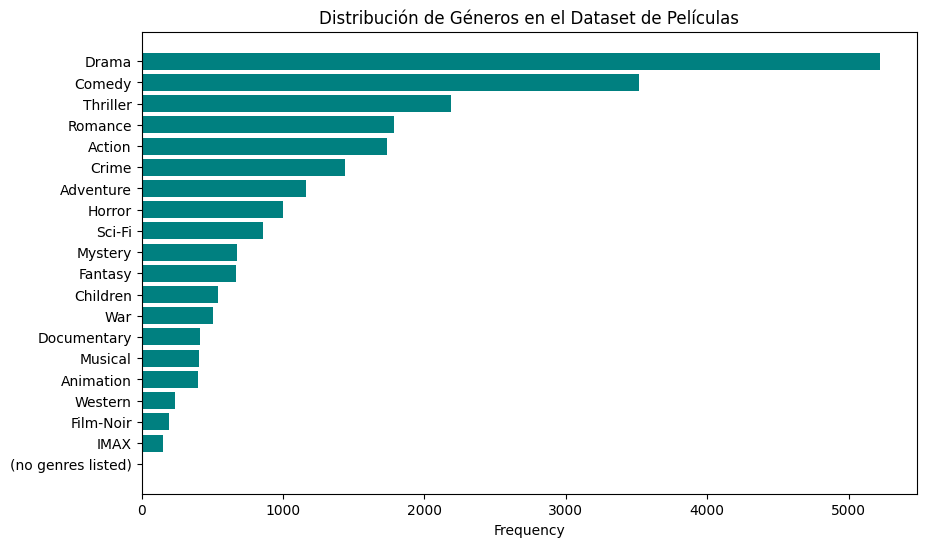

In [19]:
# Crear la columna de géneros como listas de géneros separados por "|"
df_movies["genres_list"] = df_movies["genres"].fillna("(no genres listed)").str.split("|")

# Ahora, contar los géneros
from collections import Counter

# Obtener una lista de todos los géneros
all_genres = [genre for genres in df_movies["genres_list"] for genre in genres]
genre_counts = Counter(all_genres)

# Visualizar la distribución de géneros
import matplotlib.pyplot as plt

# Convertir a un DataFrame para visualización
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])
genre_df = genre_df.sort_values(by='Count', ascending=False)

# Graficar la distribución de géneros
plt.figure(figsize=(10, 6))
plt.barh(genre_df['Genre'], genre_df['Count'], color='teal')
plt.xlabel('Frequency')
plt.title('Distribución de Géneros en el Dataset de Películas')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar los géneros más frecuentes arriba
plt.show()

El gráfico muestra la distribución de géneros dentro del conjunto de datos de películas. Se puede observar que ciertos géneros son mucho más frecuentes que otros, lo que refleja las tendencias en el contenido de las películas presentes en el dataset:

* Drama es el género más frecuente, con una clara ventaja sobre los demás, lo que indica que una gran proporción de las películas en el dataset pertenecen a este género.

* Comedia sigue de cerca, ocupando la segunda posición, lo que sugiere que las películas cómicas son también una parte significativa del conjunto de datos.

* Thriller y Romance también tienen frecuencias altas, lo que refleja una variada oferta de géneros más allá de los dos géneros más dominantes.

* Géneros como Acción, Crimen y Aventura también aparecen con una frecuencia notable, pero con una menor cantidad en comparación con los géneros más predominantes como Drama y Comedia.

* Al final de la lista se encuentran géneros como IMAX, Film-Noir y Western, que son menos representados en el conjunto de datos, lo que sugiere que no son tan comunes dentro de las películas en este dataset.

Este gráfico nos es útil para entender cómo se distribuyen los géneros dentro de las películas y puede ayudar a personalizar las recomendaciones.

## Matriz de correlación

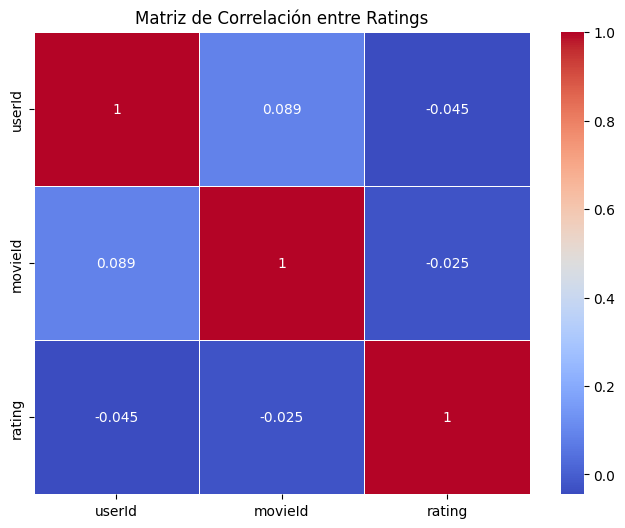

In [18]:
# Si tenemos más de una columna numérica, solo nos aseguramos de que sean numéricas
df_ratings_numeric = df_ratings[['userId', 'movieId', 'rating']].copy()

# Generamos la matriz de correlación entre ratings (usando solo la columna 'rating')
correlation_matrix = df_ratings_numeric.corr()

# Visualización de la matriz de correlación
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación entre Ratings")
plt.show()


La matriz de correlación muestra que las relaciones entre userId, movieId y rating son mínimas. Las correlaciones de 0.089 entre userId y movieId, -0.045 entre userId y rating, y -0.025 entre movieId y rating indican que no existe una relación directa entre estos valores. Esto es esperado, ya que las calificaciones son subjetivas y no dependen de los identificadores de usuario o película.

#Modelo de Machine Learning

## Preparación de los datos

In [20]:
# Crear una matriz de usuario-película con las calificaciones
df_ratings_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating')

# Rellenar los valores faltantes con el promedio global (puedes usar otras estrategias)
df_ratings_matrix = df_ratings_matrix.fillna(df_ratings_matrix.mean().mean())

# Visualización de la matriz de calificaciones
df_ratings_matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,...,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211
2,5.000000,3.177211,2.000000,3.177211,3.000000,3.177211,3.177211,3.177211,3.177211,3.177211,...,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211
3,3.177211,3.177211,3.177211,3.177211,3.000000,3.177211,3.000000,3.177211,3.177211,3.177211,...,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211
4,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,...,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211
5,4.000000,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,...,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211,3.177211


## Entrenamiento

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Convertir la matriz de calificaciones a un formato adecuado para KNN
X = df_ratings_matrix.values  # Los ratings son los datos de entrada (features)

# Crear y entrenar el modelo KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)  # Usamos 11 para incluir la película misma
knn.fit(X)

# Ver el modelo KNN (para verificar la cantidad de vecinos)
knn.n_neighbors

11

In [23]:
# Función para recomendar películas basadas en el índice de la película
def recomendar_peliculas(movie_id, model=knn, n_recommendations=5):
    # Obtener el índice de la película
    movie_idx = df_ratings_matrix.columns.get_loc(movie_id)

    # Encontrar las películas más similares
    distances, indices = model.kneighbors([X[movie_idx]], n_neighbors=n_recommendations+1)

    # Mostrar las recomendaciones
    recommendations = []
    for i in range(1, len(indices[0])):
        recommended_movie_id = df_ratings_matrix.columns[indices[0][i]]
        recommended_movie_title = df_movies[df_movies['movieId'] == recommended_movie_id]['title'].values[0]
        recommendations.append((recommended_movie_title, distances[0][i]))

    return recommendations

# Probar con una película específica (ejemplo: movieId = 1)
recommended_movies = recomendar_peliculas(1, knn, 5)
print("Películas recomendadas:")
for movie, distance in recommended_movies:
    print(f"{movie} - Distancia: {distance}")


Películas recomendadas:
Blue Sky (1994) - Distancia: 0.0007195459788212899
Antonia's Line (Antonia) (1995) - Distancia: 0.0007871227328672958
Othello (1995) - Distancia: 0.0008003284739788175
Mary Reilly (1996) - Distancia: 0.0008083830819572979
Lord of Illusions (1995) - Distancia: 0.0008104147331161604


## Evaluación

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

def predecir_rating(user_id, movie_id, model=knn):
    # Obtener el índice del usuario y de la película
    user_idx = df_ratings_matrix.index.get_loc(user_id)
    movie_idx = df_ratings_matrix.columns.get_loc(movie_id)

    # Obtener los vecinos más cercanos para ese usuario
    distances, indices = model.kneighbors([X[user_idx]], n_neighbors=11)  # Usamos 11 para incluir al propio usuario

    # Calcular la predicción como un promedio ponderado de los ratings de los vecinos
    weighted_ratings = np.dot(distances[0][1:], X[indices[0][1:]])  # Excluir el usuario mismo
    prediction = weighted_ratings / np.sum(distances[0][1:])

    # Devolver la predicción como un único valor
    return prediction[0] if isinstance(prediction, np.ndarray) else prediction

In [32]:
# Evaluar las predicciones usando una pequeña muestra de datos
sample_predictions = []
sample_real = []
for user_id in df_ratings["userId"].unique()[:30]:  # Solo 30 usuarios para acelerar
    user_ratings = df_ratings[df_ratings["userId"] == user_id]
    for _, row in user_ratings.iterrows():
        movie_id = row["movieId"]
        real_rating = row["rating"]

        # Predecir el rating
        predicted_rating = predecir_rating(user_id, movie_id)

        # Validar que la predicción no sea None o inválida
        if predicted_rating is not None and not np.isnan(predicted_rating):
            sample_predictions.append(predicted_rating)
            sample_real.append(real_rating)

# Verificar que las listas tengan la misma longitud
print(f"Longitud de las predicciones: {len(sample_predictions)}")
print(f"Longitud de los valores reales: {len(sample_real)}")

# Calcular el RMSE si las listas son del mismo tamaño
if len(sample_predictions) == len(sample_real):
    rmse = np.sqrt(mean_squared_error(sample_real, sample_predictions))
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("Las listas de predicciones y valores reales no tienen la misma longitud.")


Longitud de las predicciones: 2854
Longitud de los valores reales: 2854
Root Mean Squared Error (RMSE): 1.114173941748423


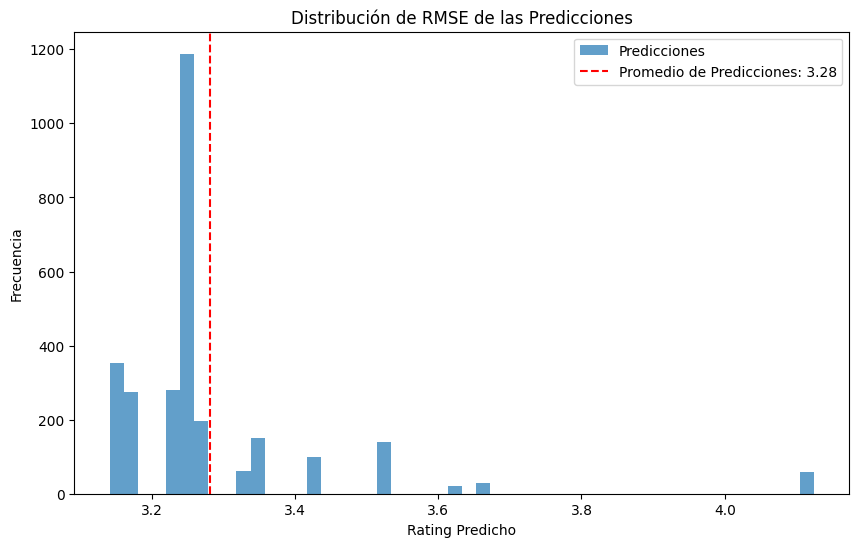

In [34]:
import matplotlib.pyplot as plt

# Graficar el RMSE para la muestra de usuarios
plt.figure(figsize=(10, 6))
plt.hist(sample_predictions, bins=50, alpha=0.7, label="Predicciones")
plt.axvline(x=np.mean(sample_predictions), color='r', linestyle='--', label=f"Promedio de Predicciones: {np.mean(sample_predictions):.2f}")
plt.title("Distribución de RMSE de las Predicciones")
plt.xlabel("Rating Predicho")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

* La longitud de las predicciones y los valores reales coincide, lo que significa que el modelo ha generado predicciones para todas las películas en la muestra. El RMSE calculado es 1.11, lo que indica que el error promedio entre las calificaciones predichas y reales es relativamente bajo, aunque puede mejorarse.

* El histograma de las predicciones muestra que la mayoría de las predicciones están cercanas a un valor de calificación de 3.2. Esto sugiere que el modelo tiene una ligera tendencia a predecir calificaciones moderadas para las películas, lo cual es común en sistemas de recomendación basados en filtros colaborativos.

#Resultados

Resultados del Modelo
RMSE (Root Mean Squared Error)

El RMSE obtenido fue de 1.11, lo que indica que las calificaciones predichas tienen un buen ajuste con las calificaciones reales, aunque aún hay margen de mejora. Un valor más bajo de RMSE indicaría una mejor capacidad del modelo para predecir con precisión las calificaciones de las películas.

Distribución de las Predicciones

El análisis de la distribución de las predicciones muestra que la mayoría de las calificaciones predichas están cercanas a un valor de 3.2, lo que sugiere que el modelo tiende a hacer predicciones moderadas. Esta distribución también muestra algunas dispersiones hacia calificaciones más altas y bajas, indicando que el modelo tiene un comportamiento más variado para las predicciones.

Conclusiones y Mejoras Futuras

Aunque el modelo muestra un rendimiento razonable en términos de RMSE, las predicciones tienden a centrarse en calificaciones moderadas. Esto sugiere que se podrían explorar ajustes adicionales en el modelo, como cambiar el número de vecinos en el algoritmo KNN o probar técnicas alternativas como Matrix Factorization o Redes Neuronales para mejorar la calidad de las recomendaciones.

# Guardado del modelo

In [42]:
import pickle

# Guardar el modelo KNN entrenado con pickle
with open('knn_movie_recommendation_model.pkl', 'wb') as f:
    pickle.dump(knn, f)
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [43]:
# Cargar el modelo KNN guardado con pickle
with open('knn_movie_recommendation_model.pkl', 'rb') as f:
    knn = pickle.load(f)
print("Modelo cargado exitosamente.")


Modelo cargado exitosamente.
